# Neural Nets using Tensorflow & Keras

## Objectives:

  * Creating a simple deep neural network.
  * Tuning the hyperparameters.

## The Dataset
  
Like previous notebooks this notebook uses the California Housing Dataset

In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity  
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


## Load the dataset

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [59]:
train_df = pd.read_csv("data/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the dataset
test_df = pd.read_csv("data/california_housing_test.csv")

## Normalize values
 
Converting each value to its Z-score.

In [60]:
# Calculating the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculating the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std


In [61]:
train_df_norm

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8985,0.3,-0.4,-0.4,-0.8,-0.9,-1.0,-0.9,-0.2,-0.8
12601,-1.1,1.4,-1.2,1.9,1.5,1.2,1.6,0.4,0.2
2756,0.9,-0.8,-2.0,2.6,1.9,2.2,1.9,1.2,0.4
9689,0.0,0.2,0.7,-0.9,-0.8,-0.7,-0.8,-1.2,-1.4
15001,-1.3,1.0,-1.9,7.3,5.6,5.2,5.8,2.0,1.2
...,...,...,...,...,...,...,...,...,...
11168,-0.7,1.6,-1.3,-0.4,-0.6,-0.5,-0.6,0.0,-0.1
14731,-1.3,1.0,1.1,-0.8,-0.7,-0.5,-0.6,-1.1,-1.0
8857,0.4,-0.7,-0.8,0.4,0.3,1.2,0.2,2.1,2.5
3913,0.8,-0.7,0.4,-0.3,-0.3,-0.4,-0.3,-0.1,-0.4


## Represent data into features

* `latitude` X `longitude` (feature cross)
* `median_income`
* `population`


In [62]:
feature_columns = []

#A resolution_in_Zs of 1 corresponds to 
# a full standard deviation
resolution_in_Zs = 0.3  # 3/10 of a standard deviation


# bucket feature column for latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)



# bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)



# feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  


# median_income as a numeric column.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)


# population as a numeric column.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)


my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model as a baseline

Before creating a deep neural network, we make a model for baseline loss by running a simple linear regression model that uses the feature layer


In [63]:
def plot_the_loss_curve(epochs, mse):
  """ curve of loss vs epoch"""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  


In [64]:
def create_model(my_learning_rate, feature_layer):
  """ a simple linear regression model."""

  model = tf.keras.models.Sequential()


  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """ train model """

  # Splitting the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   


In [65]:
import warnings
warnings.filterwarnings('ignore') 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#suppressing warnings

Epoch 1/15
17/17 [==============================] - 0s 1ms/step - loss: 0.7901 - mean_squared_error: 0.7901
Epoch 2/15
17/17 [==============================] - 0s 1ms/step - loss: 0.5439 - mean_squared_error: 0.5439
Epoch 3/15
17/17 [==============================] - 0s 1ms/step - loss: 0.4311 - mean_squared_error: 0.4311
Epoch 4/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3824 - mean_squared_error: 0.3824
Epoch 5/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3670 - mean_squared_error: 0.3670
Epoch 6/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3626 - mean_squared_error: 0.3626
Epoch 7/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3607 - mean_squared_error: 0.3607
Epoch 8/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3601 - mean_squared_error: 0.3601
Epoch 9/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3602 - mean_squared_error: 0.3602
Epoch 10/15
17/17 [=========

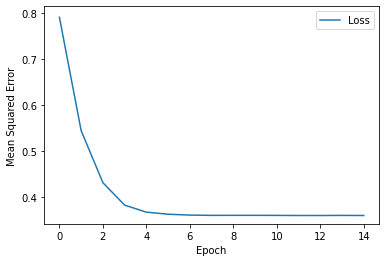


 Evaluating the linear regression model against the test set:
3/3 [==============================] - 0s 1ms/step - loss: 0.3954 - mean_squared_error: 0.3954


[0.3953688442707062, 0.3953688442707062]

In [66]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"


my_model = create_model(learning_rate, my_feature_layer)


epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolating the label


print("\n Evaluating the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Defining a deep neural network model

The `create_model` function defines:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the activation function of each layer

In [67]:
def create_model(my_learning_rate, my_feature_layer):
  """ neural net model """
  
  model = tf.keras.models.Sequential()

  
  model.add(my_feature_layer)


  # hidden layer with 15 nodes  
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # hidden layer with 10 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # output layer
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

## Defining a training function

The `train_model` function trains the model from the input features and labels.  

In [68]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """ model train """

  # Splitting the dataset into features and label
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 


  epochs = history.epoch
  
  
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

## Calling the functions to build and train a deep neural net

Epoch 1/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5625 - mean_squared_error: 0.5625
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3593 - mean_squared_error: 0.3593
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3428 - mean_squared_error: 0.3428
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3380 - mean_squared_error: 0.3380
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3359 - mean_squared_error: 0.3359
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3341 - mean_squared_error: 0.3341
Epoch 7/20
17/17 [==============================] - 0s 1ms/step - loss: 0.3330 - mean_squared_error: 0.3330
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3322 - mean_squared_error: 0.3322
Epoch 9/20
17/17 [==============================] - 0s 1ms/step - loss: 0.3315 - mean_squared_error: 0.3315
Epoch 10/20
17/17 [=========

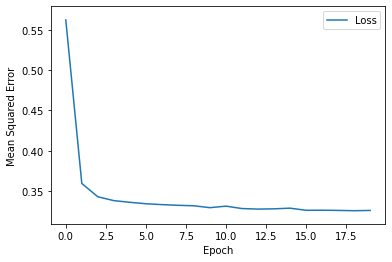


 Evaluating the new model against the test set:
3/3 [==============================] - 0s 1ms/step - loss: 0.3678 - mean_squared_error: 0.3678


[0.3678416311740875, 0.3678416311740875]

In [69]:
learning_rate = 0.01
epochs = 20
batch_size = 1000

# label
label_name = "median_house_value"

my_model = create_model(learning_rate, my_feature_layer)

# the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)


# testing that model against test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluating the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

#### Training loss is much higher, so we need to regularize the model.

## Regularizing the neural network

The model's loss against the test set is much higher than the training set. The deep neural network is overfitting to the data.  

Epoch 1/30
17/17 [==============================] - 0s 1ms/step - loss: 1.2501 - mean_squared_error: 1.0442
Epoch 2/30
17/17 [==============================] - 0s 1ms/step - loss: 0.9406 - mean_squared_error: 0.8374
Epoch 3/30
17/17 [==============================] - 0s 1ms/step - loss: 0.7481 - mean_squared_error: 0.6654
Epoch 4/30
17/17 [==============================] - 0s 1ms/step - loss: 0.6531 - mean_squared_error: 0.5784
Epoch 5/30
17/17 [==============================] - 0s 1ms/step - loss: 0.5951 - mean_squared_error: 0.5291
Epoch 6/30
17/17 [==============================] - 0s 1ms/step - loss: 0.5535 - mean_squared_error: 0.4929
Epoch 7/30
17/17 [==============================] - 0s 1ms/step - loss: 0.5225 - mean_squared_error: 0.4660
Epoch 8/30
17/17 [==============================] - 0s 1ms/step - loss: 0.4984 - mean_squared_error: 0.4451
Epoch 9/30
17/17 [==============================] - 0s 2ms/step - loss: 0.4798 - mean_squared_error: 0.4297
Epoch 10/30
17/17 [=========

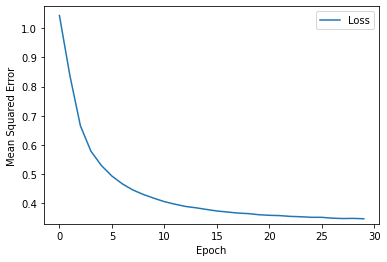


 Evaluating the new model against the test set:
3/3 [==============================] - 0s 1ms/step - loss: 0.4069 - mean_squared_error: 0.3791


[0.40691956877708435, 0.37906786799430847]

In [70]:
def create_model(my_learning_rate, my_feature_layer):


  model = None


  model = tf.keras.models.Sequential()


  model.add(my_feature_layer)



  # implementing l1 regularization
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l1(0.002),
                                  name='Hidden1'))
  
  # Implementing l1 regularization 
  model.add(tf.keras.layers.Dense(units=6, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l1(0.002),
                                  name='Hidden2'))

  # output layer
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     

""" Calling the new create_model function """
learning_rate = 0.007
epochs = 30
batch_size = 1000

label_name = "median_house_value"


my_model = create_model(learning_rate, my_feature_layer)



epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)


test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluating the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 

#### The model's loss agaisnt the test set is still much higher than the training set

## L2 Regularization

Epoch 1/20
17/17 [==============================] - 0s 1ms/step - loss: 0.5875 - mean_squared_error: 0.5661
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4051 - mean_squared_error: 0.3872
Epoch 3/20
17/17 [==============================] - 0s 1ms/step - loss: 0.3765 - mean_squared_error: 0.3605
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3685 - mean_squared_error: 0.3532
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3643 - mean_squared_error: 0.3496
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3621 - mean_squared_error: 0.3482
Epoch 7/20
17/17 [==============================] - 0s 1ms/step - loss: 0.3599 - mean_squared_error: 0.3465
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3580 - mean_squared_error: 0.3450
Epoch 9/20
17/17 [==============================] - 0s 1ms/step - loss: 0.3573 - mean_squared_error: 0.3447
Epoch 10/20
17/17 [=========

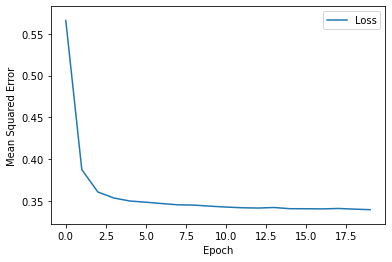


 Evaluating the new model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.3862 - mean_squared_error: 0.3757


[0.3861525058746338, 0.3756600022315979]

In [71]:
def create_model(my_learning_rate, my_feature_layer):


  model = None


  model = tf.keras.models.Sequential()


  model.add(my_feature_layer)



  # implementing l2 regularization
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='tanh',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))
  
  # Implementing L2 regularization 
  model.add(tf.keras.layers.Dense(units=6, 
                                  activation='tanh', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden2'))

  # output layer
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     

""" Calling the new create_model function """
learning_rate = 0.005
epochs = 20
batch_size = 1000

label_name = "median_house_value"


my_model = create_model(learning_rate, my_feature_layer)



epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)


test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluating the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 